In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

from torchvision import transforms,datasets
import torchvision
import numpy as np
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from tqdm import tqdm
import h5py
import seaborn as sns
import os 
import pickle

import lossclass.loss as loss
os.environ['KMP_DUPLICATE_LIB_OK']='True'

C:\ProgramData\Anaconda3\envs\Data_Science\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\ProgramData\Anaconda3\envs\Data_Science\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.current_device()

0

In [4]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='NVIDIA GeForce GTX 1050', major=6, minor=1, total_memory=4095MB, multi_processor_count=5)

In [5]:
torch.cuda.memory_allocated(0)

0

## Prepare Data

In [6]:
class TumorDataset(Dataset):
    def __init__(self, root_dir, transform=True, DEBUG=False):

        self.root_dir = root_dir
        self.default_transformation = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((512, 512))
        ])
        self.DEBUG = DEBUG

    def __getitem__(self, index):
        image_name = os.path.join(self.root_dir, str(index)+'.png')
        mask_name = os.path.join(self.root_dir, str(index)+'_mask.png')

        image = Image.open(image_name)
        mask = Image.open(mask_name)

        image = self.default_transformation(image)
        mask = self.default_transformation(mask)

        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)

        sample = {'index': int(index), 'image': image, 'mask': mask}
        return sample

    def __len__(self):
        error_msg = 'Part of dataset is missing!\nNumber of tumor and mask images are not same.'
        total_files = len(os.listdir(self.root_dir))

        assert (total_files % 2 == 0), error_msg
        return total_files//2

In [7]:
DATASET_USED = 'png_dataset'


In [71]:
def get_indices(length, new=False):
    file_path = os.path.join('dataset',f'split_indices_{DATASET_USED}.p')
    data = dict()

    # File not found or fresh copy is required.
    indices = list(range(length))
    np.random.shuffle(indices)
    split = int(np.floor(0.2 * len(tumor_dataset)))
    train_indices , test_indices = indices[split:], indices[:split]
    # Indices are saved with pickle.
    data['train_indices'] = train_indices
    data['test_indices'] = test_indices
    return train_indices, test_indices

In [72]:
tumor_dataset = TumorDataset("dataset/png_dataset")

In [74]:
train_indices, test_indices = get_indices(len(tumor_dataset))
print(len(train_indices))
print(len(test_indices))

2452
612


In [11]:
from torch.utils.data import SubsetRandomSampler

In [12]:
train_sampler, test_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(test_indices)

In [13]:
trainloader = torch.utils.data.DataLoader(tumor_dataset, 6, sampler=train_sampler)
testloader = torch.utils.data.DataLoader(tumor_dataset, 1, sampler=test_sampler)

In [14]:
for x,data in enumerate(trainloader):
    break
data["image"][0].shape


torch.Size([1, 512, 512])

In [15]:
# Create Model

In [16]:
class UNet(nn.Module):
    def __init__(self,filters,input_size=1,out_size=1):
        super().__init__()
        #filters=[16,32,64,128,256]
        #Down Block1
        self.conv1_1=nn.Conv2d(input_size,filters[0],kernel_size=3,padding=1)
        self.conv1_2=nn.Conv2d(filters[0],filters[0],kernel_size=3,padding=1)
        self.pool1=nn.MaxPool2d(2)
        #Block2
        self.conv2_1=nn.Conv2d(filters[0],filters[1],kernel_size=3,padding=1)
        self.conv2_2=nn.Conv2d(filters[1],filters[1],kernel_size=3,padding=1)
        self.pool2=nn.MaxPool2d(2)
        #Block 3 
        self.conv3_1=nn.Conv2d(filters[1],filters[2],kernel_size=3,padding=1)
        self.conv3_2=nn.Conv2d(filters[2],filters[2],kernel_size=3,padding=1)
        self.pool3=nn.MaxPool2d(2)     
        # Block 4
        self.conv4_1=nn.Conv2d(filters[2],filters[3],kernel_size=3,padding=1)
        self.conv4_2=nn.Conv2d(filters[3],filters[3],kernel_size=3,padding=1)
        self.pool4=nn.MaxPool2d(2)  
        
        # Bottleneck
        self.conv5_1=nn.Conv2d(filters[3],filters[4],kernel_size=3,padding=1)
        self.conv5_2=nn.Conv2d(filters[4],filters[4],kernel_size=3,padding=1)
        self.conv5_t=nn.ConvTranspose2d(filters[4],filters[3],kernel_size=2,stride=2)
        #Up Bloks [1]
        self.conv6_1=nn.Conv2d(filters[4],filters[3],kernel_size=3,padding=1)
        self.conv6_2=nn.Conv2d(filters[3],filters[3],kernel_size=3,padding=1)
        self.conv6_t=nn.ConvTranspose2d(filters[3],filters[2],kernel_size=2,stride=2)
        
        #Block [2]
        self.conv7_1=nn.Conv2d(filters[3],filters[2],kernel_size=3,padding=1)
        self.conv7_2=nn.Conv2d(filters[2],filters[2],kernel_size=3,padding=1)
        self.conv7_t=nn.ConvTranspose2d(filters[2],filters[1],kernel_size=2,stride=2)
        #Block [3]
        self.conv8_1=nn.Conv2d(filters[2],filters[1],kernel_size=3,padding=1)
        self.conv8_2=nn.Conv2d(filters[1],filters[1],kernel_size=3,padding=1)
        self.conv8_t=nn.ConvTranspose2d(filters[1],filters[0],kernel_size=2,stride=2)
        
        #Block [4]
        self.conv9_1=nn.Conv2d(filters[1],filters[0],kernel_size=3,padding=1)
        self.conv9_2=nn.Conv2d(filters[0],filters[0],kernel_size=3,padding=1)
        
        #Output 
        
        self.conv10=nn.Conv2d(filters[0],out_size,kernel_size=3,padding=1)
        
        
    def forward(self,x):
        #Down
        conv1=F.relu(self.conv1_1(x))
        conv1=F.relu(self.conv1_2(conv1))
        pool1=self.pool1(conv1)
        
        conv2=F.relu(self.conv2_1(pool1))
        conv2=F.relu(self.conv2_2(conv2))
        pool2=self.pool2(conv2)
        
        conv3=F.relu(self.conv3_1(pool2))
        conv3=F.relu(self.conv3_2(conv3))
        pool3=self.pool3(conv3)
        
        conv4=F.relu(self.conv4_1(pool3))
        conv4=F.relu(self.conv4_2(conv4))
        pool4=self.pool4(conv4)
        
        #Bottleneck
        
        conv5=F.relu(self.conv5_1(pool4))
        conv5=F.relu(self.conv5_2(conv5))
        
        #Up
        up6=torch.cat((self.conv5_t(conv5),conv4),dim=1)
        conv6=F.relu(self.conv6_1(up6))
        conv6=F.relu(self.conv6_2(conv6))
        
        up7=torch.cat((self.conv6_t(conv6),conv3),dim=1)
        conv7=F.relu(self.conv7_1(up7))
        conv7=F.relu(self.conv7_2(conv7))

        up8=torch.cat((self.conv7_t(conv7),conv2),dim=1)
        conv8=F.relu(self.conv8_1(up8))
        conv8=F.relu(self.conv8_2(conv8))
        
        
        up9=torch.cat((self.conv8_t(conv8),conv1),dim=1)
        conv9=F.relu(self.conv9_1(up9))
        conv9=F.relu(self.conv9_2(conv9))
        
        out=F.sigmoid(self.conv10(conv9))
        
        
        
        
        return out
        
        
        
    

In [17]:
model=UNet(filters=[16,32,64,128,256]).cuda()
model

UNet(
  (conv1_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5_1): Con

In [18]:
torch.cuda.memory_allocated(0)

7770624

In [19]:
torch.cuda.max_memory_allocated(0)

7770624

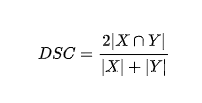

In [20]:
criterion=loss.BCEDiceLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
epochs=40
epoch_loss=[]
test_losses=[]

In [21]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    7588 KB |    7588 KB |    7588 KB |       0 B  |
|       from large pool |    4608 KB |    4608 KB |    4608 KB |       0 B  |
|       from small pool |    2980 KB |    2980 KB |    2980 KB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |    7588 KB |    7588 KB |    7588 KB |       0 B  |
|       from large pool |    4608 KB |    4608 KB |    4608 KB |

In [22]:
for epoch in range(epochs):
    for i,(data) in enumerate(trainloader):
        x=data["image"].cuda()
        y=data["mask"].cuda()
        optimizer.zero_grad()
        
        out=model(x)
        
        loss=criterion(out,y)
        
        loss.backward()
        optimizer.step()
        
        if i%400==0:
            print("Epoch {} Batch {} Loss {}".format(epoch,i,loss.item()))
    epoch_loss.append(loss.item())
    if (loss.item()<=0.75):
        torch.save(model.state_dict(),"my_model.pt")
    with torch.no_grad():
        for batch,(data) in enumerate(testloader):
            image=data["image"].cuda()
            mask=data["mask"].cuda()
            
            pred=model(image)
            
        loss=criterion(pred,mask)
        test_losses.append(loss.item())  
        
            

C:\ProgramData\Anaconda3\envs\Data_Science\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0 Batch 0 Loss 1.6777126789093018
Epoch 0 Batch 400 Loss 0.9404540061950684
Epoch 1 Batch 0 Loss 0.9588520526885986
Epoch 1 Batch 400 Loss 0.6447611451148987
Epoch 2 Batch 0 Loss 0.7294578552246094
Epoch 2 Batch 400 Loss 0.6555832624435425
Epoch 3 Batch 0 Loss 0.502528727054596
Epoch 3 Batch 400 Loss 0.7899094820022583
Epoch 4 Batch 0 Loss 0.7991757988929749
Epoch 4 Batch 400 Loss 0.3772859275341034
Epoch 5 Batch 0 Loss 0.4838273823261261
Epoch 5 Batch 400 Loss 0.33411309123039246
Epoch 6 Batch 0 Loss 0.5334155559539795
Epoch 6 Batch 400 Loss 0.5027477741241455
Epoch 7 Batch 0 Loss 0.3103272318840027
Epoch 7 Batch 400 Loss 0.544492244720459
Epoch 8 Batch 0 Loss 0.45857948064804077
Epoch 8 Batch 400 Loss 0.3468672037124634
Epoch 9 Batch 0 Loss 0.4564239978790283
Epoch 9 Batch 400 Loss 0.4296496510505676
Epoch 10 Batch 0 Loss 0.7734897136688232
Epoch 10 Batch 400 Loss 0.16689561307430267
Epoch 11 Batch 0 Loss 0.2992420792579651
Epoch 11 Batch 400 Loss 0.2831736207008362
Epoch 12 Ba

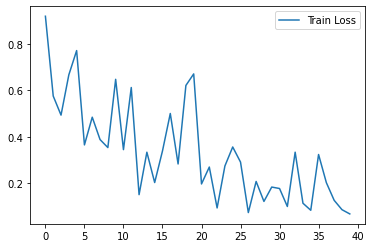

In [24]:
plt.plot(epoch_loss,label="Train Loss")
plt.legend()

In [25]:
pre_trained_model=UNet(filters=[16,32,64,128,256])

In [26]:
pre_trained_model.load_state_dict(torch.load("my_model.pt"))

<All keys matched successfully>

In [27]:
pre_trained_model.eval()

UNet(
  (conv1_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5_1): Con

In [47]:
import cv2

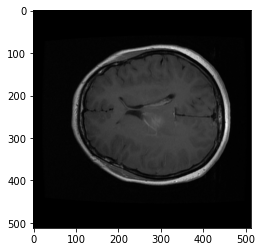

In [67]:
img=Image.open("dataset/png_dataset/8.png")
mask=Image.open("dataset/png_dataset/8_mask.png")
plt.imshow(img)

trans=transforms.Compose([transforms.Grayscale(),
            transforms.Resize((512, 512))])
img=trans(img)
img=TF.to_tensor(img)
img=img.numpy()
image_tensor=torch.Tensor(img)
image_tensor=image_tensor.view((-1,1,512,512))

In [68]:
with torch.no_grad():
    out=pre_trained_model(image_tensor)
out = out.numpy()
out = np.resize(out, (512, 512))

In [70]:
mask1=Image.fromarray(out)
mask1=np.mat(mask1)
img=np.mat(img)
total_img=cv2.add(img,mask1)
cv2.imshow("Mask_Out",total_img)
cv2.waitKey(0)

-1

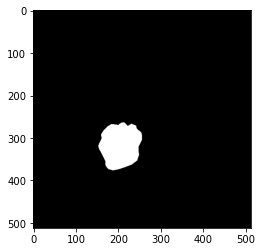

In [43]:
plt.imshow(mask)